In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from scipy import stats
%matplotlib widget

In [7]:
def load_corr(modalities, table_name, table_parent='tables'):
    df_list = []
    for modality in modalities:
        df = pd.read_csv(f'{table_parent}/Overlay/{modality}/{table_name}')
        cc1 = df[df['Component'] == 'CC 1'].copy()
        cc1['subject_num'] = cc1['Subject ID'].str.extract('(\d+)', expand=False).astype(int)
        cc1 = cc1.sort_values(by='subject_num').drop(columns='subject_num')
        cc2 = df[df['Component'] == 'CC 2'].copy()
        cc2['subject_num'] = cc2['Subject ID'].str.extract('(\d+)', expand=False).astype(int)
        cc2 = cc2.sort_values(by='subject_num').drop(columns='subject_num')
        cc1_cc2 = pd.concat([cc1, cc2], ignore_index=True)
        cc1_cc2['Modality'] = modality
        df_list.append(cc1_cc2[['Subject ID', 'Sig Level', 'Component', 'Att', 'Unatt', 'Modality']])
    corr_test = pd.concat(df_list, ignore_index=True)
    corr_test = corr_test.melt(id_vars=['Subject ID', 'Sig Level', 'Component', 'Modality'], value_vars=['Att', 'Unatt'], var_name='Attention', value_name='Corr')
    return corr_test

def load_acc(modalities, table_name, column='Trial_len=30', table_parent='tables'):
    acc = []
    for modality in modalities:
        table = pd.read_csv(f'{table_parent}/Overlay/{modality}/{table_name}')
        table['Modality'] = modality
        table = table.rename(columns={column: 'Accuracy'})
        table['subject_num'] = table['Subject ID'].str.extract('(\d+)', expand=False).astype(int)
        table = table.sort_values(by='subject_num').drop(columns='subject_num')
        acc.append(table[['Subject ID', 'Accuracy', 'Modality']])
    acc_df = pd.concat(acc, ignore_index=True)
    return acc_df

def load_isc(modalities, nb_comp=3, OVERLAY=True, table_parent='tables'):
    isc = []
    for modality in modalities:
        table_path = f'{table_parent}/Overlay/GCCA/OL_Single_Mod.csv' if OVERLAY else f'{table_parent}/Overlay/GCCA/SO_Single_Mod.csv'
        df_isc = pd.read_csv(table_path)
        df_isc = df_isc[df_isc['Modality'] == modality]
        comp_list = [f'CC {i}' for i in range(1, nb_comp+1)]
        isc.append(df_isc[df_isc['Component'].isin(comp_list)])
    isc_df = pd.concat(isc)
    return isc_df

def load_isc_folds(modalities, xth_comp=1, OVERLAY=True, table_parent='tables'):
    isc = []
    for modality in modalities:
        table_path = f'{table_parent}/Overlay/GCCA/OL_Folds.csv' if OVERLAY else f'{table_parent}/Overlay/GCCA/SO_Folds.csv'
        df_isc = pd.read_csv(table_path)
        df_isc = df_isc[df_isc['Modality'] == modality]
        df_isc = df_isc[df_isc['Component'] == f'CC {xth_comp}']
        isc.append(df_isc)
    isc_df = pd.concat(isc)
    return isc_df

def plot_corr_mod(df_long, mod, ax):
    df_long = df_long[df_long['Modality'] == mod]
    sig_level_pool = df_long['Sig Level'].mean()
    palette = dict(zip(df_long['Attention'].unique(), sns.color_palette()))
    boxprops = {'edgecolor': 'black', 'alpha': 0.5}
    sns.boxplot(x='Component', y='Corr', hue='Attention', data=df_long, showfliers=False, dodge=True, ax=ax, boxprops=boxprops, palette=palette)
    sns.stripplot(x='Component', y='Corr', hue='Attention', data=df_long, size=4, jitter=True, dodge=True, ax=ax, legend=False)
    ax.hlines(sig_level_pool, -0.5, 1.5, color='grey', linestyle='--')
    ax.set_title(mod)
    ax.set_ylabel('')
    ax.set_xlabel('')
    return ax.get_legend_handles_labels()

def wilcoxon_pvalue(comparisons, alternative, BH_correction=False, PAIRED=True):
    # comparisons is a list of tuples, where each tuple contains two lists of values to compare
    p_values = []
    for group_1, group_2 in comparisons:
        p_value = stats.wilcoxon(group_1, group_2, alternative=alternative).pvalue if PAIRED else stats.mannwhitneyu(group_1, group_2, alternative=alternative).pvalue
        p_values.append(p_value)
    if BH_correction:
        p_values = stats.false_discovery_control(p_values, method='bh')
    return p_values

def plot_pvalue(df, val_name, comparisons, alternative, BH_correction, ax, PAIRED=True, hpara=[1.5, 0]):
    modalities = df['Modality'].unique()
    comp_groups = []
    comp_groups = [(df[df['Modality'] == mod_pair[0]][val_name], df[df['Modality'] == mod_pair[1]][val_name]) for mod_pair in comparisons]
    p_values = wilcoxon_pvalue(comp_groups, alternative, BH_correction, PAIRED)
    for i in range(len(comparisons)):
        mod1, mod2 = comparisons[i]
        x1 = list(modalities).index(mod1)
        x2 = list(modalities).index(mod2)
        y, h, col = df[val_name].max() + hpara[0]*(x1+x2) - hpara[1], 0.5, 'k'
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col, clip_on=False)
        p_value = p_values[i]
        ax.text((x1+x2)*.5, y+h, f"p = {p_value:.3f}", ha='center', va='bottom', color=col)

# def plot_acc(df, title, ax, comparisons=None, alternative=None, BH_correction=None, xlabel=True):
#     sns.boxplot(x='Modality', y='Accuracy', data=df, color='lightgray', ax=ax)
#     sns.stripplot(x='Modality', y='Accuracy', hue='Subject ID', data=df, jitter=True, ax=ax, legend=False)
#     if comparisons is not None:
#         plot_pvalue(df, 'Accuracy', comparisons, alternative, BH_correction, ax)
#     if title is not None:
#         ax.set_title(title)
#     ax.set_ylabel('Accuracy')
#     ax.set_xlabel('Modality') if xlabel else ax.set_xlabel('')
#     ax.legend()

def plot_acc(df, title, ax, comparisons=None, alternative=None, BH_correction=None, xlabel=True, hpara=[1.5, 0], top=100):
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    # Convert Accuracy to percentage
    df_copy['Accuracy'] = df_copy['Accuracy'] * 100
    sns.boxplot(x='Modality', y='Accuracy', data=df_copy, showfliers=False, color='lightgray', ax=ax)
    sns.stripplot(x='Modality', y='Accuracy', hue='Subject ID', data=df_copy, jitter=True, ax=ax, legend=False)
    if comparisons is not None:
        plot_pvalue(df_copy, 'Accuracy', comparisons, alternative, BH_correction, ax, hpara=hpara)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Modality') if xlabel else ax.set_xlabel('')
    ax.set_ylim(top=top)   # Set y-axis limit from 0% to 100%
    # Remove the top and right spines (boundaries)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()

def plot_corr(df, comp, att, title, ax, comparisons=None, alternative=None, BH_correction=None):
    df = df[df['Component'] == comp]
    df = df[df['Attention'] == att]
    sns.boxplot(x='Modality', y='Corr', data=df, showfliers=False, color='lightgray', ax=ax)
    sns.stripplot(x='Modality', y='Corr', hue='Subject ID', data=df, jitter=True, ax=ax, legend=False)
    if comparisons is not None:
        plot_pvalue(df, 'Corr', comparisons, alternative, BH_correction, ax)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Modality')
    ax.legend()

def plot_compare(df_long, df_long_cp, df_mode, df_cp_mode, comp, mode, title, ax, alternative, BH_correction, PAIRED=True, Mod_to_Compare='All'):
    df_long = df_long[df_long['Component'] == comp] if comp is not None else df_long
    df_long = df_long[df_long['Attention'] == mode] if mode is not None else df_long
    df_long_cp = df_long_cp[df_long_cp['Component'] == comp] if comp is not None else df_long_cp
    df_long_cp = df_long_cp[df_long_cp['Attention'] == mode] if mode is not None else df_long_cp
    MODE = 'CC' if comp is not None else 'Acc'
    # Add a new column to distinguish between masked and unmasked modalities
    df_long['CP'] = df_mode
    df_long_cp['CP'] = df_cp_mode
    # Concatenate the dataframes
    df_combined = pd.concat([df_long, df_long_cp])
    if MODE == 'Acc':
        df_combined['Value'] = df_combined['Value'] * 100
    # Create a color palette that maps 'Modality' levels to colors
    boxprops = dict(edgecolor='black', alpha=0.5)
    sns.boxplot(x='Modality', y='Value', hue='CP', data=df_combined, showfliers=False, dodge=True, ax=ax, boxprops=boxprops)
    sns.stripplot(x='Modality', y='Value', hue='CP', data=df_combined, size=4, jitter=True, dodge=True, ax=ax, legend=False)
    modalities = df_combined['Modality'].unique() if Mod_to_Compare == 'All' else Mod_to_Compare
    comparisons = [(df_combined[(df_combined['Modality'] == modality) & (df_combined['CP'] == df_mode)]['Value'], df_combined[(df_combined['Modality'] == modality) & (df_combined['CP'] == df_cp_mode)]['Value']) for modality in modalities]
    p_values = wilcoxon_pvalue(comparisons, alternative, BH_correction, PAIRED)
    for i in range(len(modalities)):
        p_value = p_values[i]
        ax.text(i, df_combined['Value'].max(), f"p = {p_value:.3f}", ha='center', va='bottom')
    ax.set_title(title) if title is not None else ax.set_title('')
    ax.set_ylabel('Correlation Coefficient') if MODE=='CC' else ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Modality')

def adjust_legend(axes, loc='best'):
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc=loc)

def plot_CC_pairs(df_long, mode='Att'):
    df_long = df_long[df_long['Attention'] == mode]
    modalities = df_long['Modality'].unique()
    fig, axes = plt.subplots(1, len(modalities), sharey=True, figsize=(10, 4))
    for mod in modalities:
        ax = axes[modalities.tolist().index(mod)]
        df_mod = df_long.loc[df_long['Modality'] == mod].copy()  # Create a copy to avoid SettingWithCopyWarning
        df_mod.loc[:, 'Component'] = (df_mod['Component'] != 'CC 1').astype(float)
        # Create a new column 'Above Sig Level' that indicates whether the correlation for 'CC1' or 'CC2' is above the significance level
        df_mod.loc[:, 'Above Sig Level'] = df_mod.groupby('Subject ID')['Corr'].transform(lambda x: any(x > df_mod['Sig Level'].mean()))
        subjects = df_mod['Subject ID'].unique()
        num_sig_subjects = sum(df_mod.groupby('Subject ID')['Above Sig Level'].any())
        for subject in subjects:
            df_subject = df_mod[df_mod['Subject ID'] == subject]
            color = 'red' if df_subject['Above Sig Level'].any() else '#3C74BC'
            sns.lineplot(x='Component', y='Corr', data=df_subject, ax=ax, marker='o', color=color, legend=False)
        ax.set_xlabel(mod)
        ax.set_ylabel('Correlation Coefficient')
        ax.set_xticks([0, 1], ['CC 1', 'CC 2'])
        ax.legend().remove()
        # Add the number of significant subjects over the total number of subjects to the top of the plot
        ax.text(0.5, 1.02, f'#sig_subj/#subj\n{num_sig_subjects}/{len(subjects)}', transform=ax.transAxes, ha='center', va='bottom')

In [3]:
table_parent='tables'
fig_save_path = '../../Manuscript/2nd/images/' if table_parent == 'tables' else 'figures_frw/'

## Correlations are modulated by attention

In [ ]:
modalities = ['EEG', 'EOG', 'GAZE', 'GAZE_V', 'EOG_V', 'SACC']
table_name = 'ObjFlow_Corr_Train_Att_Mask_False.csv'
corr_df = load_corr(modalities, table_name, table_parent=table_parent)

plt.close('all')
fig, axes = plt.subplots(1, len(modalities), figsize=(13, 6), sharey=True)
for i, ax in enumerate(axes):
    h, l = plot_corr_mod(corr_df, modalities[i], ax)
    ax.legend().remove()  # Remove the legend from each subplot
axes[0].set_ylabel('Correlation')
significance_line = mlines.Line2D([], [], color='grey', linestyle='--', label='Significance Level')
h.append(significance_line)
l.append('Significance Level')
fig.legend(h, l, loc='upper center', ncol=len(h))
plt.show()
# plt.savefig(fig_save_path + 'corr_mod.jpg', dpi=300)

In [ ]:
# plt.close('all')
# plot_CC_pairs(corr_df, 'Att')
# plt.tight_layout()
# plt.show()

In [ ]:
# plt.close('all')
# plot_CC_pairs(corr_df, 'Unatt')
# plt.tight_layout()
# plt.show()

## Performance of visual attention decoding tasks

In [ ]:
modalities = ['EEG', 'EOG', 'GAZE', 'GAZE_V', 'EOG_V', 'SACC']
table_name = 'ObjFlow_Acc_Train_Att_Mask_False.csv'
acc_df = load_acc(modalities, table_name, table_parent=table_parent)
comparisons = [('EEG', 'GAZE_V'), ('GAZE_V', 'SACC'), ('EEG', 'SACC')]
alternative = 'two-sided' # Whether the compared distributions are significantly different
BH_correction = True
plt.close('all')
fig, ax = plt.figure(figsize=(6, 4)), plt.gca()
plot_acc(acc_df, None, ax, comparisons, alternative, BH_correction)
plt.show()
# plt.savefig(fig_save_path + 'acc_vad_mod.jpg', dpi=300)

In [ ]:
# modalities = ['EEG', 'EOG', 'GAZE', 'GAZE_V', 'EOG_V', 'SACC']
# table_name = 'ObjFlow_Acc_Train_Att_Mask_False.csv'
# acc_df_frw = load_acc(modalities, table_name, table_parent=table_parent)
# acc_df_frw = acc_df_frw.rename(columns={'Accuracy': 'Value'})
# acc_df_ori = load_acc(modalities, table_name, table_parent='tables/')
# acc_df_ori = acc_df_ori.rename(columns={'Accuracy': 'Value'})

# plt.close('all')
# fig, ax = plt.figure(figsize=(12, 4)), plt.gca()
# plot_compare(acc_df_frw, acc_df_ori, 'Gaze-Informed', 'ObjFlow', None, None, None, ax, 'greater', True)
# adjust_legend([ax], 'lower right')
# plt.show()
# plt.savefig(fig_save_path + 'acc_vad_comp.jpg', dpi=300)

In [ ]:
modalities = ['EEG', 'GAZE_V', 'SACC']
table_name = 'ObjFlow_Acc_Train_SO_Mask_False.csv'
acc_df_SO = load_acc(modalities, table_name, table_parent=table_parent)
acc_df_SO = acc_df_SO.rename(columns={'Accuracy': 'Value'})
table_name = 'ObjFlow_Acc_Train_Att_Mask_False.csv'
acc_df = load_acc(modalities, table_name, table_parent=table_parent)
acc_df = acc_df.rename(columns={'Accuracy': 'Value'})

plt.close('all')
fig, ax = plt.figure(figsize=(6, 5)), plt.gca()
plot_compare(acc_df, acc_df_SO, 'Train with overlaid objects', 'Train with single object', None, None, None, ax, 'two-sided', True)
adjust_legend([ax])

# plt.savefig(fig_save_path + 'acc_vad_SO.jpg', dpi=300)

## Performance when regressing out eye movements from EEG

In [ ]:
table_name = 'ObjFlow_Acc_Train_Att_Mask_False.csv'
modalities = ['EEG', 'EEG-EOG&GAZE_V']
acc_reg_df = load_acc(modalities, table_name, table_parent=table_parent)
comparisons = [('EEG', 'EEG-EOG&GAZE_V')]
alternative = 'greater' # Whether the compared distributions are significantly different
BH_correction = True
plt.close('all')
fig, ax = plt.figure(figsize=(3.8, 4)), plt.gca()
# plot_acc(acc_reg_df, None, ax, comparisons, alternative, BH_correction)
plot_acc(acc_reg_df, None, ax, top=85)
plt.show()
# plt.savefig(fig_save_path + 'acc_reg_eye.jpg', dpi=300)

In [ ]:
# table_name = 'ObjFlow_Acc_Train_Att_Mask_False.csv'
# modalities = ['EEG', 'EEG-EOG&GAZE&GAZE_V']
# acc_reg_df_frw = load_acc(modalities, table_name, table_parent=table_parent)
# acc_reg_df = load_acc(modalities, table_name, table_parent='tables/')

# p_value = wilcoxon_pvalue([(acc_reg_df[acc_reg_df_frw['Modality'] == 'EEG-EOG&GAZE&GAZE_V']['Accuracy'], acc_reg_df_frw[acc_reg_df_frw['Modality'] == 'EEG-EOG&GAZE&GAZE_V']['Accuracy'])], alternative='less', BH_correction=False)[0]
# comparisons = [('EEG', 'EEG-EOG&GAZE&GAZE_V')]
# alternative = 'greater' # Whether the compared distributions are significantly different
# BH_correction = True
# plt.close('all')
# fig, axes = plt.subplots(1, 2, sharey=True)
# plot_acc(acc_reg_df, 'With ObjFlow', axes[0], top=85)
# plot_acc(acc_reg_df_frw, 'With gaze-informed feature', axes[1], top=85)
# plt.suptitle(f'Is the performance with gaze-informed feature better \n using EEG (eye movements regressed out)? p = {p_value:.3f}', y=1)
# plt.show()
# plt.savefig(fig_save_path + 'acc_reg_eye.jpg', dpi=300)



## Performance when using a subset of electrodes in the visual cortex

In [ ]:
# import mne
# region_dict = {
#     'frontal': ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8'],
#     'frontal_central': ['FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6'],
#     'temporal': ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8'],
#     'central_parietal': ['CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10'],
#     'parietal_occipital': ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz'],
#     'selected': ['PO7', 'PO4', 'Oz', 'O1']
# }
# nb_regions = len(region_dict)
# montage = mne.channels.make_standard_montage('biosemi64')
# for region, kept_channels in region_dict.items():
#     ind = [i for (i, channel) in enumerate(montage.ch_names) if channel in kept_channels]
#     montage_selected = montage.copy()
#     # Keep only the desired channels
#     montage_selected.ch_names = [montage.ch_names[x] for x in ind]
#     kept_channel_info = [montage.dig[x+3] for x in ind] # Skip the first three as they are LPA, Nasion, and RPA
#     montage_selected.dig = montage.dig[0:3]+kept_channel_info # Keep the first three rows as they are the fiducial points information
#     fig = montage_selected.plot(show=False, show_names=False)
#     fig.savefig(fig_save_path+region+'.jpg', dpi=300)

In [ ]:
regions = ['frontal', 'frontal_central', 'temporal', 'central_parietal', 'parietal_occipital']
# load and concatenate the dataframes of different regions
acc_df = []
modalities = ['EEG']
table_name = 'Objflow_Acc_Train_Att_Mask_False.csv'
acc = load_acc(modalities, table_name, table_parent=table_parent)
acc['Modality'] = 'whole brain'
acc_df.append(acc)

for region in reversed(regions):
    table_name = region+'-OF_Acc_Train_Att_Mask_False.csv'
    acc = load_acc(modalities, table_name, table_parent=table_parent)
    acc['Modality'] = region
    acc_df.append(acc)
acc_df = pd.concat(acc_df)

plt.close('all')
fig, ax = plt.figure(figsize=(10, 5)), plt.gca()
comparisons = [('whole brain', 'parietal_occipital'), ('whole brain', 'frontal_central'), ('whole brain', 'frontal'), ('whole brain', 'temporal'), ('whole brain', 'central_parietal')]
alternative = 'greater' # Whether the compared distributions are significantly different
BH_correction = True
plot_acc(acc_df, None, ax, comparisons, alternative, BH_correction, xlabel=False, hpara=[2.8, 0])
plt.show()
# plt.savefig(fig_save_path + 'acc_regions.jpg', dpi=300)

In [ ]:
modalities = ['EEG']
# load and concatenate the dataframes of different regions
acc_df = []
table_name = 'Objflow_Acc_Train_Att_Mask_False.csv'
acc = load_acc(modalities, table_name, table_parent=table_parent)
acc['Modality'] = 'whole brain'
acc_df.append(acc)
# table_name = 'selected-OF_Acc_Train_Att_Mask_False.csv'
# table_name = 'further_rm_POz-OF_Acc_Train_Att_Mask_False.csv'
table_name = 'rm_Oz-OF_Acc_Train_Att_Mask_False.csv'
acc = load_acc(modalities, table_name, table_parent=table_parent)
acc['Modality'] = 'selected'
acc_df.append(acc)
for run in range(1,11):
    table_name = f'Run-{run}-Rand4Ref-OF_Acc_Train_Att_Mask_False.csv'
    acc = load_acc(modalities, table_name, table_parent=table_parent)
    acc['Modality'] = f'Rand-{run}'
    acc_df.append(acc)
acc_df = pd.concat(acc_df)

plt.close('all')
fig, ax = plt.figure(figsize=(13, 6)), plt.gca()
comparisons = [('whole brain', 'selected'), ('whole brain', 'Rand-1'), ('whole brain', 'Rand-2'), ('whole brain', 'Rand-3'), ('whole brain', 'Rand-4'), ('whole brain', 'Rand-5'), ('whole brain', 'Rand-6'), ('whole brain', 'Rand-7'), ('whole brain', 'Rand-8'), ('whole brain', 'Rand-9'), ('whole brain', 'Rand-10')]
alternative = 'greater' # Whether the compared distributions are significantly different
BH_correction = True
plot_acc(acc_df, None, ax, comparisons, alternative, BH_correction, xlabel=False, hpara=[2.5, 0])
plt.show()
# plt.savefig(fig_save_path + 'acc_four_ch.jpg', dpi=300)

## Performance after removing saccades

In [ ]:
modalities = ['EEG']
acc_df = []
table_name = 'ObjFlow_Acc_Train_Aug_Multisubj_Syn_False.csv'
acc = load_acc(modalities, table_name, column='Trial_len=30', table_parent=table_parent)
acc['Modality'] = 'No SACC'
acc_df.append(acc)
for run in range(10):
    table_name = f'Run{run+1}-ObjFlow_Acc_Train_Aug_Multisubj_Syn_True.csv'
    acc = load_acc(modalities, table_name, table_parent=table_parent)
    acc['Modality'] = f'Control-{run+1}'
    acc_df.append(acc)
acc_df = pd.concat(acc_df)

plt.close('all')
fig, ax = plt.figure(figsize=(12, 6)), plt.gca()
comparisons = [('No SACC', 'Control-1'), ('No SACC', 'Control-2'), ('No SACC', 'Control-3'), ('No SACC', 'Control-4'), ('No SACC', 'Control-5'), ('No SACC', 'Control-6'), ('No SACC', 'Control-7'), ('No SACC', 'Control-8'), ('No SACC', 'Control-9'), ('No SACC', 'Control-10')]
alternative = 'less' # Whether the compared distributions are significantly different
BH_correction = True
plot_acc(acc_df, None, ax, comparisons, alternative, BH_correction, xlabel=False, hpara=[2.5, 10])
plt.show()
# plt.savefig(fig_save_path + 'acc_wo_sacc.jpg', dpi=300)


## MM vs VAD

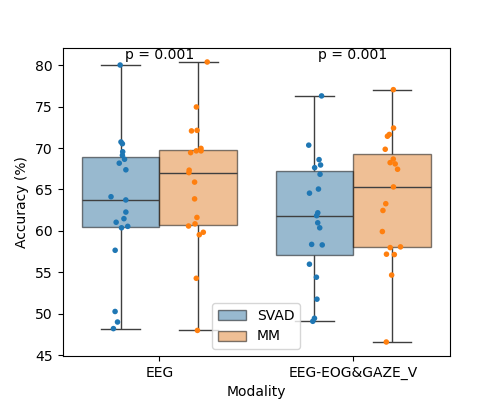

In [25]:
modalities = ['EEG', 'EEG-EOG&GAZE_V']
table_name = 'ObjFlow_Acc_MM_Train_Att_Mask_False_CB.csv'
acc_mm_df = load_acc(modalities, table_name, table_parent=table_parent)
acc_mm_df = acc_mm_df.rename(columns={'Accuracy': 'Value'})
table_name = 'ObjFlow_Acc_Train_Att_Mask_False_CB.csv'
acc_df = load_acc(modalities, table_name, table_parent=table_parent)
acc_df = acc_df.rename(columns={'Accuracy': 'Value'})

plt.close('all')
fig, ax = plt.figure(figsize=(5, 4)), plt.gca()
plot_compare(acc_df, acc_mm_df, 'SVAD', 'MM', None, None, None, ax, 'less', True)
adjust_legend([ax])
plt.savefig(fig_save_path + 'acc_vad_mm.jpg', dpi=300)

In [ ]:
# modalities = ['EOG', 'GAZE', 'GAZE_V', 'EOG_V', 'SACC']
# # modalities = ['EEG', 'EEG-EOG&GAZE_V']
# table_name = 'ObjFlow_Acc_MM_Train_Att_Mask_False_CB.csv'
# acc_mm_df = load_acc(modalities, table_name, table_parent=table_parent)
# acc_mm_df = acc_mm_df.rename(columns={'Accuracy': 'Value'})
# table_name = 'ObjFlow_Acc_Train_Att_Mask_False_CB.csv'
# acc_df = load_acc(modalities, table_name, table_parent=table_parent)
# acc_df = acc_df.rename(columns={'Accuracy': 'Value'})

# plt.close('all')
# fig, ax = plt.figure(figsize=(10, 4)), plt.gca()
# plot_compare(acc_df, acc_mm_df, 'SVAD', 'MM', None, None, None, ax, 'greater', True)
# adjust_legend([ax], loc='lower right')
# # plt.savefig(fig_save_path + 'acc_vad_mm_other.jpg', dpi=300)


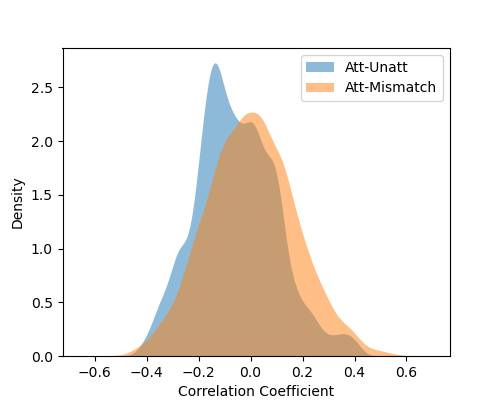

In [21]:
Subj_ID = 0
modality = 'EEG'
file = f'{table_parent}/Overlay/{modality}/{Subj_ID}_VAD_MM_Corrdict_Len_30.pkl'
with open(file, 'rb') as f:
    corr_dict = pickle.load(f)

eeg_att = corr_dict['EEG_Att']
eeg_unatt = corr_dict['EEG_Unatt']
eeg_mm = corr_dict['EEG_MM']
att_unatt = corr_dict['Att_Unatt']
att_mm = corr_dict['Att_MM']

plt.close('all')
plt.figure(figsize=(5, 4)) 
sns.kdeplot(att_unatt, label='Att-Unatt', fill=True, alpha=0.5, linewidth=0)
sns.kdeplot(att_mm, label='Att-Mismatch', fill=True, alpha=0.5, linewidth=0)
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.show()
# plt.savefig(fig_save_path + 'att_unatt_mm.jpg', dpi=300)

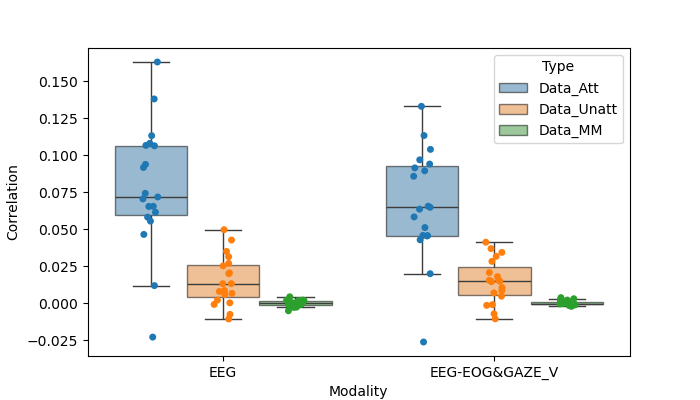

In [20]:
modalities = ['EEG', 'EEG-EOG&GAZE_V', 'EOG', 'GAZE', 'GAZE_V', 'EOG_V', 'SACC']
nb_subj = 19
# create a dataframe to store the correlation coefficients
df = pd.DataFrame(columns=['Subject ID', 'Modality', 'Correlation', 'Type'])
i = 0
for modality in modalities:
    for Subj_ID in range(nb_subj):
        file = f'{table_parent}/Overlay/{modality}/{Subj_ID}_VAD_MM_Corrdict_Len_30.pkl'
        with open(file, 'rb') as f:
            corr_dict = pickle.load(f)
        eeg_att = corr_dict['EEG_Att'][:,:2]
        eeg_att_avg = np.sum(np.mean(eeg_att, axis=0))
        df.loc[i] = ['Subj '+str(Subj_ID+1), modality, eeg_att_avg, 'Data_Att']
        eeg_unatt = corr_dict['EEG_Unatt'][:,:2]
        eeg_unatt_avg = np.sum(np.mean(eeg_unatt, axis=0))
        df.loc[i+1] = ['Subj '+str(Subj_ID+1), modality, eeg_unatt_avg, 'Data_Unatt']
        eeg_mismatch = corr_dict['EEG_MM'][:,:2]
        eeg_mismatch_avg = np.sum(np.mean(eeg_mismatch, axis=0))
        df.loc[i+2] = ['Subj '+str(Subj_ID+1), modality, eeg_mismatch_avg, 'Data_MM']
        i += 3


plot_mod = ['EEG', 'EEG-EOG&GAZE_V']
plt.close('all')
fig, ax = plt.figure(figsize=(7, 4)), plt.gca()
corr_plot = []
for i, mod in enumerate(plot_mod):
    table = df[df['Modality'] == mod].copy()
    table['subject_num'] = table['Subject ID'].str.extract('(\d+)', expand=False).astype(int)
    table = table.sort_values(by='subject_num').drop(columns='subject_num')
    corr_plot.append(table)
df_plot = pd.concat(corr_plot, ignore_index=True)
boxprops = dict(edgecolor='black', alpha=0.5)
sns.boxplot(x='Modality', y='Correlation', data=df_plot, hue='Type', dodge=True, ax=ax, showfliers=False, boxprops=boxprops)
sns.stripplot(x='Modality', y='Correlation', data=df_plot, hue='Type', jitter=True, dodge=True, ax=ax, legend=False)
plt.show()
# plt.savefig(fig_save_path + 'eeg_att_unatt_mm.jpg', dpi=300)

In [ ]:
# modalities = ['EEG']

# regions = ['frontal', 'frontal_central', 'temporal', 'central_parietal', 'parietal_occipital']
# # load and concatenate the dataframes of different regions
# acc_df = []
# acc_mm_df = []
# modalities = ['EEG']
# for region in reversed(regions):
#     table_name = region+'-OF_Acc_Train_Att_Mask_False.csv'
#     acc = load_acc(modalities, table_name, table_parent=table_parent)
#     acc['Modality'] = region
#     acc_df.append(acc)
#     table_name = region+'-OF_Acc_MM_Train_Att_Mask_False.csv'
#     acc_mm = load_acc(modalities, table_name, table_parent=table_parent)
#     acc_mm['Modality'] = region
#     acc_mm_df.append(acc_mm)
# acc_df = pd.concat(acc_df)
# acc_mm_df = pd.concat(acc_mm_df)
# acc_df = acc_df.rename(columns={'Accuracy': 'Value'})
# acc_mm_df = acc_mm_df.rename(columns={'Accuracy': 'Value'})

# plt.close('all')
# fig, ax = plt.figure(figsize=(10, 4)), plt.gca()
# plot_compare(acc_df, acc_mm_df, 'VAD', 'MM', None, None, None, ax, 'less', True)
# adjust_legend([ax])


## Combining EEG and GAZE_V

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


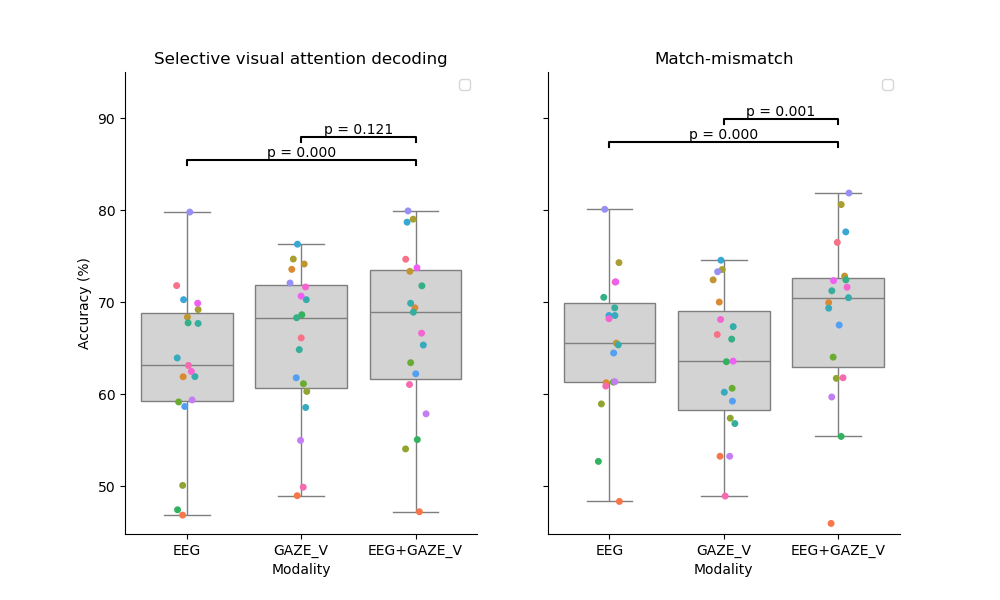

In [12]:
modalities = ['EEG', 'GAZE_V', 'EEG+GAZE_V']
table_name = 'ObjFlow_Acc_Train_Att_Mask_False.csv'
acc_comb_df = load_acc(modalities, table_name, table_parent=table_parent)
table_name = 'ObjFlow_Acc_MM_Train_Att_Mask_False.csv'
acc_comb_mm_df = load_acc(modalities, table_name, table_parent=table_parent)

plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
comparisons = [('EEG', 'EEG+GAZE_V'), ('GAZE_V', 'EEG+GAZE_V')]
alternative = 'less'
BH_correction = True
plot_acc(acc_comb_df, 'Selective visual attention decoding', axes[0], comparisons, alternative, BH_correction, top=95, hpara=[2.5, 0])
plot_acc(acc_comb_mm_df, 'Match-mismatch', axes[1], comparisons, alternative, BH_correction, top=95, hpara=[2.5, 0])
plt.show()
# plt.savefig(fig_save_path + 'acc_vad_mm_comb.jpg', dpi=300)

## GCCA

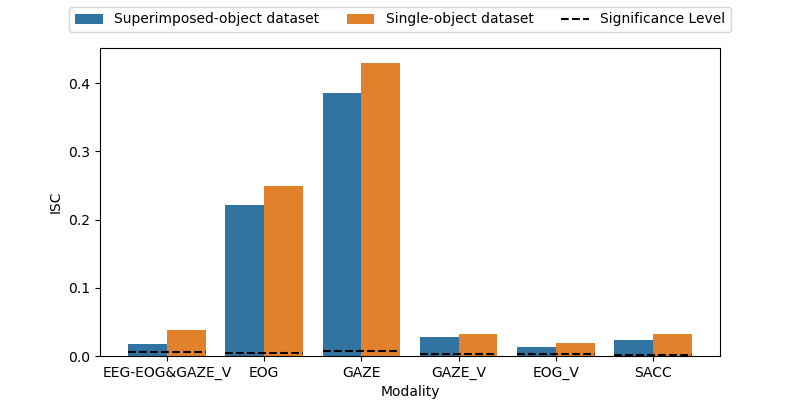

In [8]:
from matplotlib.lines import Line2D
modalities = ['EEG-EOG&GAZE_V', 'EOG', 'GAZE', 'GAZE_V', 'EOG_V', 'SACC']
isc_df_ol = load_isc(modalities, nb_comp=1, OVERLAY=True, table_parent=table_parent)
isc_df_ol['Dataset'] = 'Superimposed-object dataset'
isc_df_sg = load_isc(modalities, nb_comp=1, OVERLAY=False, table_parent=table_parent)
isc_df_sg['Dataset'] = 'Single-object dataset'
isc_df = pd.concat([isc_df_ol, isc_df_sg])

plt.close('all')
fig, ax = plt.figure(figsize=(8, 4)), plt.gca()
sns.barplot(isc_df, x="Modality", y="ISC", hue="Dataset")
for i, mod in enumerate(isc_df['Modality'].unique()):
    sig_level = isc_df[isc_df['Modality'] == mod]['Sig Level (ISC)'].mean()
    ax.hlines(sig_level, i-0.4, i+0.4, color='black', linestyle='--')
h, l = ax.get_legend_handles_labels()
ax.legend().remove() 
significance_line = Line2D([0], [0], color='black', linestyle='--')
h.append(significance_line)
l.append('Significance Level')
fig.legend(h, l, loc='upper center', ncol=len(h))
plt.show()
# plt.savefig(fig_save_path + 'isc.jpg', dpi=300)


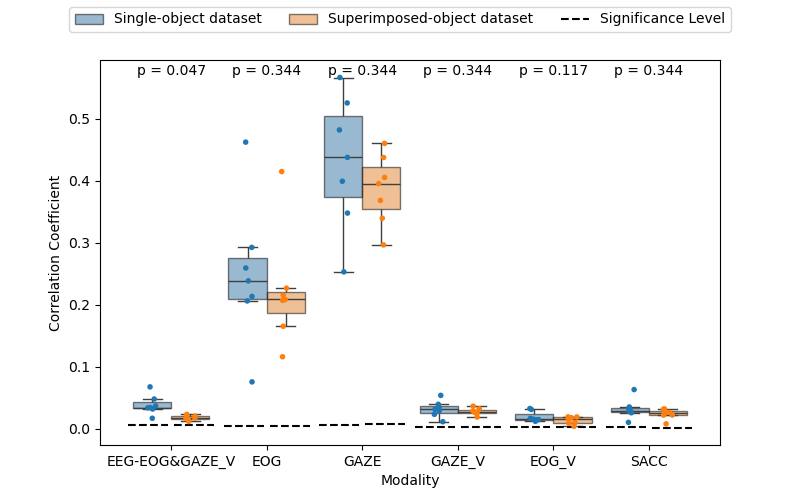

In [22]:
modalities = ['EEG-EOG&GAZE_V', 'EOG', 'GAZE', 'GAZE_V', 'EOG_V', 'SACC']
isc_df_sg_folds = load_isc_folds(modalities, xth_comp=1, OVERLAY=False, table_parent='tables')
isc_df_sg_folds = isc_df_sg_folds.rename(columns={'ISC': 'Value'})
isc_df_ol_folds = load_isc_folds(modalities, xth_comp=1, OVERLAY=True, table_parent='tables')
isc_df_ol_folds = isc_df_ol_folds.rename(columns={'ISC': 'Value'})

plt.close('all')
fig, ax = plt.figure(figsize=(8, 5)), plt.gca()
plot_compare(isc_df_sg_folds, isc_df_ol_folds, 'Single-object dataset', 'Superimposed-object dataset', 'CC 1', None, None, ax, 'greater', True, PAIRED=True)
for i, mod in enumerate(modalities):
    sig_level_SO = isc_df_sg_folds[isc_df_sg_folds['Modality'] == mod]['Sig Level (ISC)'].mean()
    sig_level_OL = isc_df_ol_folds[isc_df_ol_folds['Modality'] == mod]['Sig Level (ISC)'].mean()
    ax.hlines(y=sig_level_SO, xmin=i-0.45, xmax=i-0.03, colors='black', linestyles='dashed')
    ax.hlines(y=sig_level_OL, xmin=i+0.03, xmax=i+0.45, colors='black', linestyles='dashed')
h, l = ax.get_legend_handles_labels()
ax.legend().remove() 
significance_line = Line2D([0], [0], color='black', linestyle='--')
h.append(significance_line)
l.append('Significance Level')
fig.legend(h, l, loc='upper center', ncol=len(h))
plt.savefig(fig_save_path + 'isc_fold.jpg', dpi=300)

## EEG vs GAZE_V, pairwise comparison

In [ ]:
modalities = ['EEG-EOG&GAZE_V', 'GAZE_V']
table_name = 'ObjFlow_Acc_Train_Att_Mask_False.csv'
acc_df = load_acc(modalities, table_name, table_parent=table_parent)
# find the subject ID where the accuracy is the higher when using EEG compared to GAZE_V
eeg_df = acc_df[(acc_df['Modality'] == 'EEG-EOG&GAZE_V')].reset_index(drop=True)
gaze_v_df = acc_df[(acc_df['Modality'] == 'GAZE_V')].reset_index(drop=True)
# print(eeg_df[eeg_df['Accuracy'] > gaze_v_df['Accuracy']])
# print(gaze_v_df[gaze_v_df['Accuracy'] > eeg_df['Accuracy']])
# correlations between the accuracy of EEG and GAZE_V
print(eeg_df['Accuracy'].corr(gaze_v_df['Accuracy']))

In [ ]:
modality = 'EEG-EOG&GAZE_V'
nb_subj = 19
# create a dataframe to store the correlation coefficients
df = pd.DataFrame(columns=['Subject ID', 'Modality', 'Correlation', 'Type'])
i = 0
for Subj_ID in range(nb_subj):
    file = f'{table_parent}/Overlay/{modality}/{Subj_ID}_VAD_MM_Corrdict_Len_30.pkl'
    with open(file, 'rb') as f:
        corr_dict = pickle.load(f)
    eeg_att = corr_dict['EEG_Att'][:,:2]
    eeg_att_avg = np.sum(np.mean(eeg_att, axis=0))
    df.loc[i] = ['Subj '+str(Subj_ID+1), modality, eeg_att_avg, 'EEG_Att']
    eeg_unatt = corr_dict['EEG_Unatt'][:,:2]
    eeg_unatt_avg = np.sum(np.mean(eeg_unatt, axis=0))
    df.loc[i+1] = ['Subj '+str(Subj_ID+1), modality, eeg_unatt_avg, 'EEG_Unatt']
    eeg_mismatch = corr_dict['EEG_MM'][:,:2]
    eeg_mismatch_avg = np.sum(np.mean(eeg_mismatch, axis=0))
    df.loc[i+2] = ['Subj '+str(Subj_ID+1), modality, eeg_mismatch_avg, 'EEG_MM']
    i += 3
df

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
acc_df['Accuracy (%)'] = acc_df['Accuracy']*100
for subject in acc_df['Subject ID'].unique():
    df_subject = acc_df[acc_df['Subject ID'] == subject]
    eeg_subject = df_subject[df_subject['Modality'] == 'EEG-EOG&GAZE_V']
    gaze_v_subject = df_subject[df_subject['Modality'] == 'GAZE_V']
    if eeg_subject['Accuracy'].values + 0.1 < gaze_v_subject['Accuracy'].values:
        # Add label=subject to ensure each line has a label corresponding to the subject ID
        sns.lineplot(x='Modality', y='Accuracy (%)', data=df_subject, ax=ax, marker='o', label=str(subject), linewidth=2.5)
    else:
        sns.lineplot(x='Modality', y='Accuracy (%)', data=df_subject, ax=ax, marker='o', linestyle=':', color='grey', label='_nolegend_')

# Display the legend. You can adjust the location by specifying the loc parameter, e.g., loc='upper right'
ax.legend(title='Subject ID', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig(fig_save_path + 'acc_pair.jpg', dpi=300)


## Scratchpad